In [1]:
from typing import Any

import equinox as eqx
import jax
import jax.numpy as jnp
import optax
import treescope
from penzai import pz

import matplotlib.pyplot as plt

from simplexity.generative_processes.hidden_markov_model import HiddenMarkovModel
from simplexity.generative_processes.transition_matrices import zero_one_random
from simplexity.predictive_models.rnn import RNN
from simplexity.training.train import train

In [2]:
treescope.basic_interactive_setup(autovisualize_arrays=True)

In [3]:
key = jax.random.PRNGKey(0)

transition_matrices = zero_one_random()
vocab_size = transition_matrices.shape[0]
generative_process = HiddenMarkovModel(transition_matrices)
initial_gen_process_state = generative_process.state_eigenvector

hidden_size = 16
key, model_key = jax.random.split(key)
model = RNN(in_size=1, out_size=vocab_size, hidden_size=hidden_size, key=model_key)
optimizer = optax.adam(learning_rate=0.001)

sequence_len = 64
batch_size = 32
num_epochs = 1000

In [4]:
model, losses = train(
    key,
    model,
    optimizer,
    generative_process,
    initial_gen_process_state,
    num_epochs,
    batch_size,
    sequence_len,
    log_every = 1,
)

[<matplotlib.lines.Line2D at 0x7f9a48117750>]

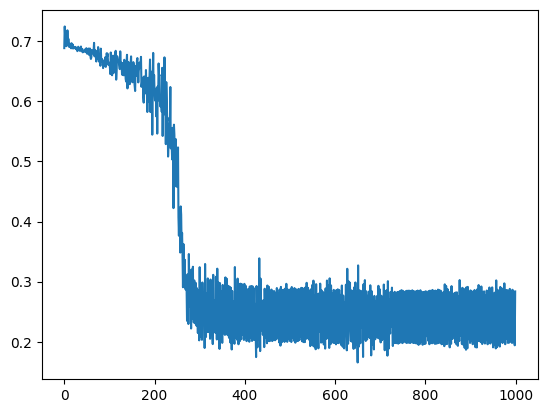

In [5]:
plt.plot(losses)

In [6]:
@pz.pytree_dataclass
class SaveActivations(pz.nn.Layer):
  saved_activations: pz.StateVariable[list[Any]]
  def __call__(self, activations: Any, **unused_side_inputs) -> Any:
    self.saved_activations.value = self.saved_activations.value + [activations]
    return activations

In [7]:
saved_activations = pz.StateVariable(value=[], label="activations")

saving_model = (
    pz.select(model)
    .at_instances_of(eqx.nn.Lambda)
    .insert_after(SaveActivations(saved_activations))
)

saving_model

RNN(
  layers=Sequential(
    layers=(
      Lambda(
        fn=GRUFn(
          hidden_size=16,
          cell=GRUCell(
            weight_ih=f32[48,1],
            weight_hh=f32[48,16],
            bias=f32[48],
            bias_n=f32[16],
            input_size=1,
            hidden_size=16,
            use_bias=True
          )
        )
      ),
      SaveActivations(
        saved_activations=StateVariable(label='activations', value=[], metadata={})
      ),
      Linear(
        weight=f32[2,16],
        bias=None,
        in_features=16,
        out_features=2,
        use_bias=False
      )
    )
  )
)

In [8]:
gen_process_states = jnp.repeat(initial_gen_process_state[None, :], batch_size, axis=0)
batch_keys = jax.random.split(key, batch_size)
_, obs = generative_process.generate(gen_process_states, batch_keys, sequence_len)
obs = obs[:, :, None]
pz.nx.wrap(obs, "batch", "sequence", "features")

<NamedArray int32(| batch:32, sequence:64, features:1) [≥0, ≤1] zero:1_038 nonzero:1_010 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>

In [9]:
logits = eqx.filter_vmap(saving_model)(obs)
logits = pz.nx.wrap(logits, "batch", "vocab")
logits

<NamedArray float32(| batch:32, vocab:2) ≈0.036 ±0.081 [≥-0.049, ≤0.12] nonzero:64 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>

In [10]:
saved_activations = saved_activations.__class__(
    value=[value.val for value in saved_activations.value],  # Convert batch traced array to regular array
    label=saved_activations.label,
    metadata=saved_activations.metadata,
)

saved_activations

StateVariable(label='activations', value=[<jax.Array float32(32, 16) ≈0.011 ±0.16 [≥-0.27, ≤0.43] nonzero:512>], metadata={})